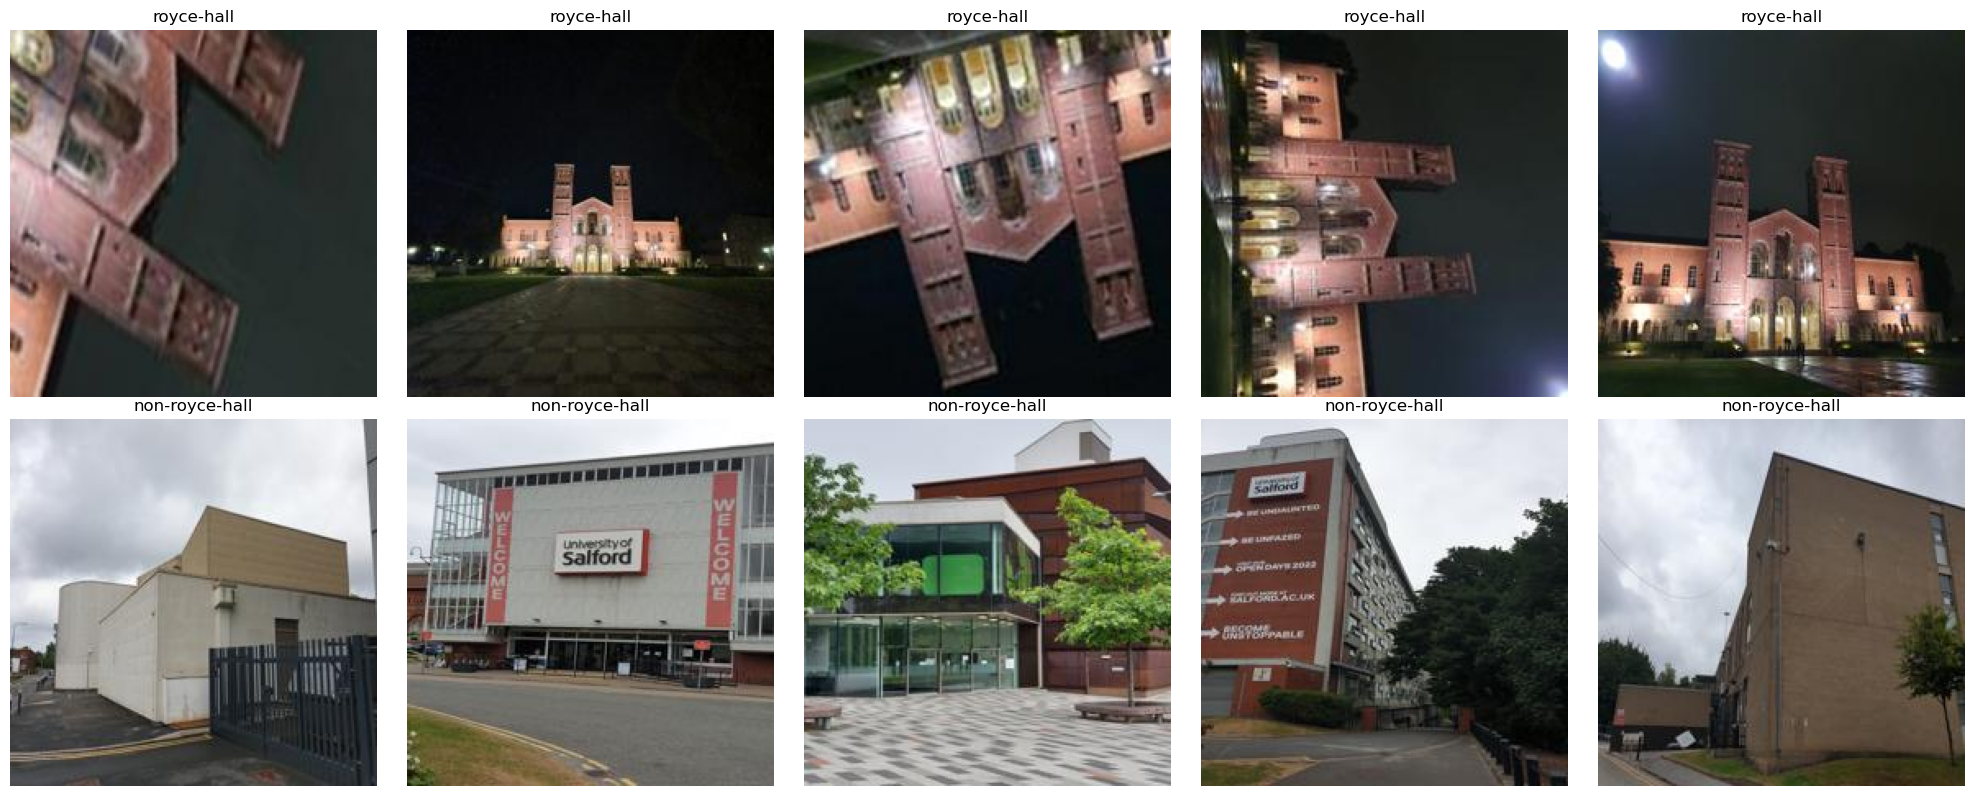

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

def plot_sample_images(dataset_path, class_names, img_height=224, img_width=224, grid_rows=2, grid_cols=5):
    """
    Plots a grid of sample images from specified classes.
    
    :param dataset_path: Path to the dataset directory
    :param class_names: List of class names (subdirectory names)
    :param img_height: Image height
    :param img_width: Image width
    :param grid_rows: Number of rows in the grid
    :param grid_cols: Number of columns in the grid
    """
    plt.figure(figsize=(20, 8))

    for row in range(grid_rows):
        class_path = os.path.join(dataset_path, class_names[row])
        images = os.listdir(class_path)
        sampled_images = random.sample(images, grid_cols)

        for col in range(grid_cols):
            img_path = os.path.join(class_path, sampled_images[col])
            img = load_img(img_path, target_size=(img_height, img_width))
            plt.subplot(grid_rows, grid_cols, row * grid_cols + col + 1)
            plt.imshow(img)
            plt.title(class_names[row])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
dataset_path = 'dataset/train_set/'
class_names = ['royce-hall', 'non-royce-hall']  # Replace with your actual class names
plot_sample_images(dataset_path, class_names)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# ImageDataGenerator for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'dataset/train_set',  # This is the source directory for training images
        target_size=(224, 224),  
        batch_size=32,
        class_mode='binary')

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'dataset/valid_set',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n // train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.n // validation_generator.batch_size)

# Evaluate the model using the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 209 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Epoch 1/20
6/6 [==============================] - 5s 681ms/step - loss: 3.0582 - accuracy: 0.5365 - val_loss: 0.7371 - val_accuracy: 0.5000
Epoch 2/20
6/6 [==============================] - 4s 652ms/step - loss: 0.8655 - accuracy: 0.7232 - val_loss: 0.7059 - val_accuracy: 0.5625
Epoch 3/20
6/6 [==============================] - 4s 789ms/step - loss: 0.6420 - accuracy: 0.7288 - val_loss: 0.7960 - val_accuracy: 0.5625
Epoch 4/20
6/6 [==============================] - 4s 666ms/step - loss: 0.5708 - accuracy: 0.7288 - val_loss: 0.6287 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 5s 847ms/step - loss: 0.5028 - accuracy: 0.7292 - val_loss: 0.5598 - val_accuracy: 0.4375
Epoch 6/20
6/6 [==============================] - 4s 655ms/step - loss: 0.4410 - accuracy: 0.7684 - val_loss: 0.7686 - val_accuracy: 0.5000
Epoch 7/20
6/6 [==============================] - 4s 622ms/step - loss: 0.2901 

In [ ]:
import io
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing import image

# Function to preprocess the image
def preprocess_image(uploaded_image, target_size=(224, 224)):
    img = uploaded_image.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

# Function to predict the class of an image
def predict(model, img_array):
    prediction = model.predict(img_array)
    return 'positive' if prediction[0][0] > 0.5 else 'negative'

# Upload button
upload_button = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Allow only single file upload
)

# Output widget to display image
output = widgets.Output()

# Function to handle upload event
def on_upload_change(change):
    if not upload_button.value:
        return

    # Get uploaded file
    uploaded_file = next(iter(upload_button.value.values()))
    content = uploaded_file['content']
    stream = io.BytesIO(content)
    uploaded_image = Image.open(stream)

    # Display the uploaded image
    with output:
        output.clear_output()
        display(uploaded_image)

    # Preprocess and predict
    img_array = preprocess_image(uploaded_image)
    prediction = predict(model, img_array)
    print(f'Predicted class: {prediction}')

# Observe upload changes
upload_button.observe(on_upload_change, names='value')

# Display widgets
display(upload_button, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()